## Import packages 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the data
print("Load")

## Generate data

In [2]:
image_size = (224, 224)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/dev/ML_Project/data/archive/images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/dev/ML_Project/data/archive/images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 20580 files belonging to 1 classes.
Using 16464 files for training.
Found 20580 files belonging to 1 classes.
Using 4116 files for validation.


# Visualize data

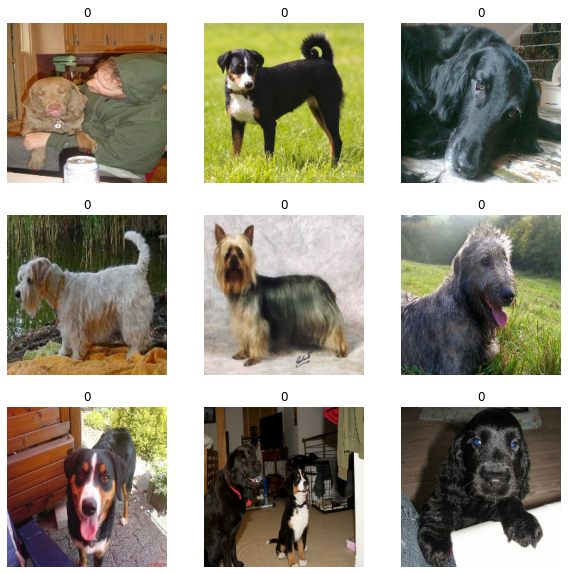

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
        
        

# Augment data
## Augment data and visualize it        
        

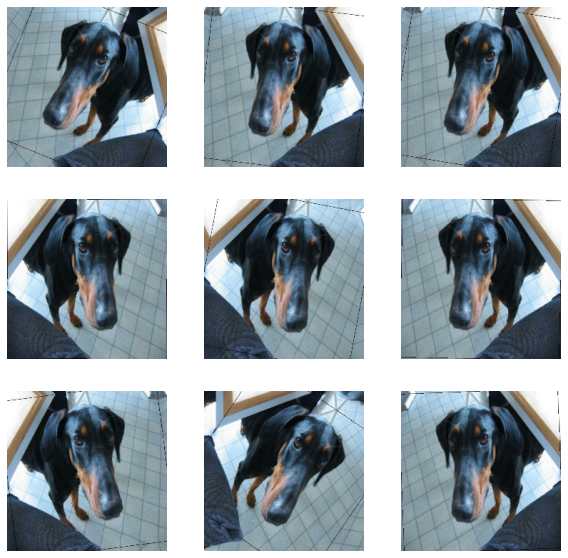

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


# Performance
Config data for preformance.        
        

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Normalize
Normalize the data within the value 0 and 1.        
        

In [ ]:
pass

# Model
Model        
        

In [6]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=120)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Fit model
Fit the model       
        

In [7]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
258/258 [==============================] - 184s 712ms/step - loss: 0.0084 - accuracy: 0.0086 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 2/50
258/258 [==============================] - 182s 704ms/step - loss: 0.0084 - accuracy: 0.0083 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 3/50
258/258 [==============================] - 181s 701ms/step - loss: 0.0084 - accuracy: 0.0050 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 4/50
258/258 [==============================] - 181s 702ms/step - loss: 0.0084 - accuracy: 0.0050 - val_loss: 0.0084 - val_accuracy: 0.0015
Epoch 5/50
258/258 [==============================] - 181s 702ms/step - loss: 0.0084 - accuracy: 0.0047 - val_loss: 0.0084 - val_accuracy: 0.0017
Epoch 6/50
258/258 [==============================] - 181s 703ms/step - loss: 0.0084 - accuracy: 0.0056 - val_loss: 0.0084 - val_accuracy: 0.0039
Epoch 7/50
145/258 [===============>..............] - ETA: 1:15 - loss: 0.0084 - accuracy: 0.0064

KeyboardInterrupt: 